# Public Eye - Sample Version

**Upload a picture of a crowd and let Public Eye count/estimate the amount of people!**

This website is a slow and minimal sample version of the full Public Eye system.

For more information about Public Eye, please get in touch at [crowdcounter@amsterdam.nl](mailto:crowdcounter@amsterdam.nl).

In [1]:
%%capture
cd ..

In [2]:
import os
import math
from tqdm.notebook import tqdm

import numpy as np
import torch

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm

import models.ViCCT_models
import models.Swin_ViCCT_models
from timm.models import create_model

from datasets.dataset_utils import img_equal_split, img_equal_unsplit
import torchvision.transforms as standard_transforms

from fastai.vision.widgets import *
from fastbook import *

# from pyngrok import ngrok

import gradio as gr

In [3]:
# # https://towardsdatascience.com/quickly-share-ml-webapps-from-google-colab-using-ngrok-for-free-ae899ca2661a
# # Open a HTTP tunnel on the default port 80
# public_url = ngrok.connect(port = '8888')
# print(public_url)

In [4]:
# Set some parameters
# Several parameters need to be defined to run this notebook.

# First, which model will we use?
# The generic ViCCT version 1 model is specified with 'ViCCT_base'. 
# The version 2 ViCCT model, which has Swin as its base, is specified with 'Swin_ViCCT_large_22k'.
# model_name = 'ViCCT_base'
model_name = 'Swin_ViCCT_large_22k'

# The model is trained to perform crowd counting. We specify here where the weights of this trained model is located.
# weights_path = 'models/trained_models/ViCCT_base_generic_1300_epochs.pth'
weights_path = 'models/trained_models/Swin_ViCCT_large_22k_generic_1600_epochs.pth'

# Some images are of extremely large resolution. When the heads in images occupy many (e.g. something like 100 x 100 
# pixels each) pixels, the model is unable to make pretty predictions. One way to overcome this issue is to scale the image
# by some factor. This factory is specified here. A factor of 1. means no scaling is performed.
# scale_factor = 1.

# We might want to save the predictions. Set 'save_results' to true if you want to save the prediction. Three figures are saved
# 1) The input image for the network. 2) The network's prediction. 3) The predictions overlayed with the input.
save_results = True

# Lastly, do we use cuda? If you have cuda, it's advised to use it.
use_cuda = True

In [5]:
# Load model
def load_model(model_name, weights_path, use_cuda):
    """ Creates the model and initialised it with the weights specified. """
    
    model = create_model(  # From the timm library. This function created the model specific architecture.
    model_name,
    init_path=weights_path,
    pretrained_cc=True,
    drop_rate=None if 'Swin' in model_name else 0.,  # Dropout

    # Bamboozled by Facebook. This isn't drop_path_rate, but rather 'drop_connect'.
    # I'm not yet sure what it is for the Swin version
    drop_path_rate=None if 'Swin' in model_name else 0.,
    drop_block_rate=None,  # Drops our entire Transformer blocks I think? Not used for ViCCT.
    )

    if use_cuda:
        model = model.cuda()  # Place model on GPU
    
    model = model.eval()
    
    return model

# print('Loading the model...')
model = load_model(model_name, weights_path, use_cuda)

/home/jongstra/.local/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
# Main Functions


# Only for hardcore users. No need to modify these.
mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Mean and std.dev. of ImageNet
overlap = 32  # We ensure crops have at least this many pixels of overlap.
ignore_buffer = 16  # When reconsturting the whole density map, ignore this many pixels on crop prediction borders.

train_img_transform = standard_transforms.Compose([
    standard_transforms.ToTensor(),
    standard_transforms.Normalize(*mean_std)
])


def rescale_image(img, scale_factor):
    # Get image dimensions
    img_w, img_h = img.size
    
    # Rescale image
    if scale_factor != 1.:
        new_w, new_h = round(img_w * scale_factor), round(img_h * scale_factor)
        img = img.resize((new_w, new_h))
    
    return img


def prepare_loaded_image(img):
    # Get image dimensions
    img_w, img_h = img.size
    
    # Before we make the prediction, we normalise the image and split it up into crops
    img = train_img_transform(img)
    img_stack = img_equal_split(img, 224, overlap)  # Split the image ensuring a minimum of 'overlap' of overlap between crops.

    if use_cuda:
        img_stack = img_stack.cuda()  # Place image stack on GPU        

    # This is the placeholder where we store the model predictions.
    pred_stack = torch.zeros(img_stack.shape[0], 1, 224, 224)
    
    return img_stack, pred_stack, img_h, img_w


def process_image(img_stack, pred_stack, img_h, img_w):
    if not use_cuda and img_stack.shape[0] > 100:  # If on CPU and more than 100 image crops.
        print('\033[93m'
              'WARNING: you are making a prediction on a very large image. This might take a long time! '
              'You may want to use a lower "Scale Factor" value for faster processing. '
              'You can stop a running process by pressing F5.'
              '\033[0m')

    with torch.no_grad():  # Dont make gradients
        print(f"Processing {len(img_stack)} image parts.")
        for idx, img_crop in enumerate(tqdm(img_stack)):  # For each image crop
            pred_stack[idx] = model.forward(img_crop.unsqueeze(0)).cpu()  # Make prediction.
    print('Done!')


    # Unsplit the perdiction crops to get the entire density map of the image.
    den = img_equal_unsplit(pred_stack, overlap, ignore_buffer, img_h, img_w, 1)
    den = den.squeeze()  # Remove the channel dimension

    # Compute the perdicted count, which is the sum of the entire density map. Note that the model is trained with density maps
    # scaled by a factor of 3000 (See sec 5.2 of my thesis for why: https://scripties.uba.uva.nl/search?id=723178). In short,
    # This works :)
    pred_cnt = den.sum() / 3000
    
    return den, pred_cnt


def show_overlay(input_image, den, pred_cnt):
    img_heat = np.array(input_image)
    den_heat = den.clone().numpy()

    den_heat = den_heat / 3000  # Scale values to original domain
    den_heat[den_heat < 0] = 0  # Remove negative values
    den_heat = den_heat / den_heat.max() # Normalise between 0 and 1

    den_heat **= 0.5  # Reduce large values, increase small values
    den_heat *= 255  # Values from 0 to 255 now
    den_heat[den_heat < 50] = 0  # Threshold of 50

    img_heat[:, :, 0][den_heat > 0] = img_heat[:, :, 0][den_heat > 0] / 2
    img_heat[:, :, 1][den_heat > 0] = img_heat[:, :, 1][den_heat > 0] / 2
    img_heat[:, :, 2][den_heat > 0] = den_heat[den_heat > 0]


#     plt.figure(figsize=(1920/200, 1080/200), dpi=200)
    plt.figure(figsize=(1440/200, 810/200), dpi=200)
    plt.imshow(img_heat)
    plt.title(f'Predicted count: {pred_cnt:.3f}')
    plt.show()

In [7]:
def show_downscaled_res_and_processing_time(x_res, y_res, slider_val):
    x_res_downscaled = int(x_res*slider_val)
    y_res_downscaled = int(y_res*slider_val)
    approximate_n_crops = round((x_res_downscaled*y_res_downscaled) / 30000) + 6 # High estimate for larger images.
    approximate_processing_time = int(approximate_n_crops / 6.5)  # on fast server.
    return x_res_downscaled, y_res_downscaled, approximate_processing_time

In [8]:
def set_scale_factor(image_input):
    try:
        y_res, x_res, rbg = image_input.shape
    except AttributeError:
        return 0, 0, 0, 0
    min_res = min(x_res, y_res)
    ideal_min = 2000
    if min_res < ideal_min:
        factor = 1
    if min_res > ideal_min:
        factor = round(ideal_min / min_res, 2) + 0.01
        if factor > 1:
            factor = 1
            
    _,_, approximate_processing_time = show_downscaled_res_and_processing_time(x_res, y_res, factor)
    
    return factor, x_res, y_res, approximate_processing_time

In [9]:
def show_slider_val(x):
    return x

In [10]:
def create_overlay_image(input_image, den, pred_cnt):
    img_heat = np.array(input_image)
    den_heat = den.clone().numpy()

    den_heat = den_heat / 3000  # Scale values to original domain
    den_heat[den_heat < 0] = 0  # Remove negative values
    den_heat = den_heat / den_heat.max() # Normalise between 0 and 1

    den_heat **= 0.5  # Reduce large values, increase small values
    den_heat *= 255  # Values from 0 to 255 now
    den_heat[den_heat < 50] = 0  # Threshold of 50

    img_heat[:, :, 0][den_heat > 0] = img_heat[:, :, 0][den_heat > 0] / 2
    img_heat[:, :, 1][den_heat > 0] = img_heat[:, :, 1][den_heat > 0] / 2
    img_heat[:, :, 2][den_heat > 0] = den_heat[den_heat > 0]

    plt.figure(figsize=(600/200, 400/200), dpi=200)
    plt.title(f'Predicted count: {pred_cnt:.1f}')
    plt.imshow(img_heat)
    
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    overlay_im = io.BytesIO()
    plt.savefig(overlay_im, format='png', bbox_inches='tight')
    overlay_im = PILImage.create(overlay_im)
    
    return overlay_im

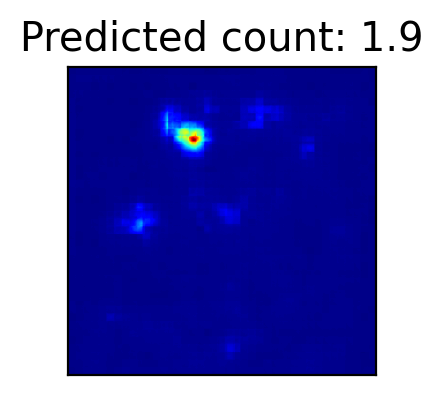

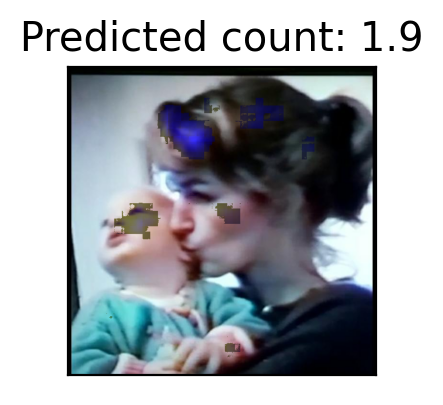

In [27]:
def count_people(image_input, scale_factor):
    image = PILImage.create(image_input)
    image = rescale_image(image, scale_factor)
    
    w, h = image.shape
    if w < 224 or h < 224:
        raise gr.Error("Image is too small, please provide a bigger image (244x244 or larger) and try again.")
        return None, None, 0
    
    img_stack, pred_stack, img_h, img_w = prepare_loaded_image(image)
    den, pred_cnt = process_image(img_stack, pred_stack, img_h, img_w)
    
    plt.figure(figsize=(600/200, 400/200), dpi=200)
    plt.title(f'Predicted count: {pred_cnt:.1f}')
    plt.imshow(den, cmap=cm.jet)
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    den_im = io.BytesIO()
    plt.savefig(den_im, format='png', bbox_inches='tight')
    den_im = PILImage.create(den_im)
    
    overlay_im = create_overlay_image(image, den, pred_cnt)

    return den_im, overlay_im, round(float(pred_cnt),1)

In [28]:
# TODO:
#
# [X] Make count button work (use model, test GPU version as well)
# [X] Put "People Count" result number above output image?
# [X] Make image blocks higher in pixels (how??).
# [X] Make "Clear Image" button work as expected. 
# [X] Build a catch when pressing the count_button if the (downscaled) image is of too low resolution.
# [ ] Fix dat beelden soms upside down staan na verwerking (rotation in exif niet goed opgepakt oid?)
# [ ] Make code nicer/better maintainable.

# [-] Fix buggy sliders (scaled res klopt niet altijd na wijzigen slider op telefoon view)
# [-] Zorgen dat croppen invloed heeft op de scale factor?
# [X] Default resolutie gebruiken (cap: 2000px) ipv scaling slider aanbieden?

import numpy as np
import gradio as gr

def reset():
    return None, None, None, None
    
# demo = gr.Blocks(css="#output_image {height: 600px !important} #count {font-weight: bold;}")

demo = gr.Blocks(title="Crowd Counter")

with demo:
    x_res = gr.Number(label="Original x resolution", interactive=False, visible=False)
    y_res = gr.Number(label="Original y resolution", interactive=False, visible=False)
    slider = gr.Slider(0.01, 1, step=0.01, value=0, label="Scale Factor", visible=False)
    x_res_downscaled = gr.Number(label="x res", interactive=False, visible=False)
    y_res_downscaled = gr.Number(label="y res", interactive=False, visible=False)
    
    gr.Markdown("# Crowd Counter")
    gr.Markdown("Upload an image & count the people.")
    image_input = gr.Image()
    clear_button = gr.Button("Reset Image", visible=False)
    appr_proc_time = gr.Number(label="Approximate Processing Time (sec)", interactive=False)
    
#     with gr.Row():
#         with gr.Column():
#             slider = gr.Slider(0.01, 1, step=0.01, value=0, label="Scale Factor", visible=False)
#             appr_proc_time = gr.Number(label="Approximate Processing Time (sec)", interactive=False)
#         with gr.Column():
#             x_res_downscaled = gr.Number(label="x res", interactive=False, visible=False)
#             y_res_downscaled = gr.Number(label="y res", interactive=False, visible=False)
    count_button = gr.Button("Count People")
    count_result = gr.Number(label="People Count", elem_id='count', visible=False)
    with gr.Row():
        image_output_overlay = gr.Image(elem_id='output_image')
        image_output = gr.Image(elem_id='output_image')
    
    # Interactions
    image_input.change(fn=set_scale_factor, inputs=image_input, outputs=[slider, x_res, y_res, appr_proc_time])
    slider.change(fn=show_downscaled_res_and_processing_time, inputs=[x_res, y_res, slider], outputs=[x_res_downscaled, y_res_downscaled, appr_proc_time])
    count_button.click(count_people, inputs=[image_input, slider], outputs=[image_output, image_output_overlay, count_result])
#     clear_button.click(reset, inputs=[], outputs=[image_input, count_result, image_output, image_output_overlay])

    # Footer
    gr.Markdown("Contact us at: [crowdcounter@amsterdam.nl](mailto:crowdcounter@amsterdam.nl)")
    gr.Markdown("Created by Thomas Jongstra 2022, for the Municipality of Amsterdam.")


# demo.queue()
demo.launch(share=False)
# demo.launch(share=True)
# demo.launch(server_port=8800, share=False)

Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x7fcb5c5ec9d0>, 'http://127.0.0.1:7867/', None)

Traceback (most recent call last):
  File "/home/jongstra/.local/lib/python3.10/site-packages/gradio/routes.py", line 275, in run_predict
    output = await app.blocks.process_api(
  File "/home/jongstra/.local/lib/python3.10/site-packages/gradio/blocks.py", line 785, in process_api
    result = await self.call_function(fn_index, inputs, iterator)
  File "/home/jongstra/.local/lib/python3.10/site-packages/gradio/blocks.py", line 694, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/home/jongstra/.local/lib/python3.10/site-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/home/jongstra/.local/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/home/jongstra/.local/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "/tmp/ipykernel_9947/941633920.py

Processing 12 image parts.


  0%|          | 0/12 [00:00<?, ?it/s]

Done!


In [ ]:
# def show_image(image, bla):
#     return image

In [ ]:
# demo = gr.Interface(
#     fn = show_image,
#     inputs = [gr.Image(type="pil"), gr.Slider(0.01, 1, step=0.01, value=0.5)],
#     outputs = ["image"]
# )
# demo.launch()

In [ ]:
# def greet(image, temperature):
#     salutation = "Good morning" if is_morning else "Good evening"
#     greeting = f"{salutation} {name}. It is {temperature} degrees today"
#     celsius = (temperature - 32) * 5 / 9
#     return greeting, round(celsius, 2)

# demo = gr.Interface(
#     fn=greet,
#     inputs=["image", gr.Slider(0.01, 1, step=0.01, value=0.5)],
#     outputs=["text", "number"],
# )

# demo.launch()

In [ ]:
# with gr.Blocks() as demo:
#     image = gr.Image()
#     slider = gr.Slider(0.01, 1, step=0.01, value=0.5)
#     image.change(set_slider, slider, slider)
    
# demo.launch()

In [ ]:
# demo = gr.Interface(
#     fn=show_image,
#     inputs=["image", "checkbox", gr.Slider(0.01, 1, step=0.01, value=0.5)],
#     outputs=["image"],
# )
# demo.launch()

In [ ]:
# with gr.Blocks() as demo:
#     output = gr.Image(label="Output Image")

# demo.launch()

In [ ]:
# demo = gr.Interface(
#     fn=show_image,
#     inputs=["image", gr.Slider(0.01, 1, step=0.01, value=0.5)],
#     outputs=["image"]
# )

# demo.launch()

In [ ]:
# demo = gr.Blocks()

# with demo:
#     im = gr.Interface(show_image, gr.Image(), "image", tool='editor', allow_flagging="never")
# #     slider = gr.Slider(0.01, 1, step=0.01, value=0.5)
# #     audio_file = gr.Audio(type="filepath")
# #     text = gr.Textbox()

# demo.launch()

In [ ]:
# # Create widget items.
# btn_upload = widgets.FileUpload(multiple=False)
# output1 = widgets.Output()
# output1.layout.height = '200px'
# scale_factor_slider = widgets.FloatSlider(value=0.5, min=0.05, max=1, step=0.01, description="Scale Factor")
# output2 = widgets.Output()
# output2.layout.height = '30px'
# output3 = widgets.Output()
# predicted_label = widgets.Label()
# btn_run = widgets.Button(description='Count People')

In [ ]:
# # Variables
# input_image = None
# x_res = None
# y_res = None

In [ ]:
# def get_scale_factor(x_res, y_res):
#     min_res = min(x_res, y_res)
#     max_res = max(x_res, y_res)
#     ideal_min = 1200
#     if min_res < ideal_min:
#         factor = 1
#     if min_res > ideal_min:
#         factor = round(ideal_min / min_res, 2) + 0.01
#         if factor > 1:
#             factor = 1
#     return factor


# def get_crops_amount(input_image, scale_factor):
#     image = rescale_image(input_image, scale_factor)
#     img_stack, pred_stack, img_h, img_w = prepare_loaded_image(image)
#     n_crops = len(img_stack)
#     return n_crops


# # Give the user some feedback and change the downscale factor, when a new image is uploaded.
# def on_data_change(data):
#     output1.clear_output()
#     with output1:
#         global input_image, x_res, y_res
#         input_image = PILImage.create(io.BytesIO(btn_upload.data[-1]))
#         y_res, x_res = input_image.shape
#         display(input_image.to_thumb(150,150))
#         if x_res<224 or y_res<224:
#             print(f"Image is too small to process, only {x_res}x{y_res} pixels.")
#             print("Please upload another image with at least 224 pixels in both dimensions.")
#         else:
#             scale_factor = get_scale_factor(x_res, y_res)
#             scale_factor_slider.value = scale_factor
#             print(f"Original image size: {x_res}x{y_res}.")
#             if scale_factor_slider.value < 1:
#                 downscale_x = int(x_res * scale_factor_slider.value)
#                 downscale_y = int(y_res * scale_factor_slider.value)
#                 print(f"Proposing to downscale to {downscale_x}x{downscale_y} (scale factor: {scale_factor_slider.value}).")
#             else:
#                 downscale_x = x_res
#                 downscale_y = y_res
#                 print("No downscaling proposed.")
# #             n_crops = get_crops_amount(input_image, scale_factor_slider.value)
# #             print(f"Processing {n_crops} crops.")
# #             approximate_n_crops = round((downscale_x*downscale_y) / 30000)  # High estimate for larger images.
# #             print(f"Approximate {approximate_n_crops} crops.")
    
# btn_upload.observe(on_data_change, names=['data'])

In [ ]:
# # Estimate processing time when changing downscale slider.

# def on_slider_change(value):
#     output2.clear_output()
#     with output2:
#         downscale_x = int(x_res * scale_factor_slider.value)
#         downscale_y = int(y_res * scale_factor_slider.value)
#         approximate_n_crops = round((downscale_x*downscale_y) / 30000) # High estimate for larger images.
#         approximate_processing_time = int(approximate_n_crops / 6.5)  # on fast server.
# #         approximate_processing_time = int(approximate_n_crops * 4.5)  # on slow server.
# #         print(f"Approximate number of crops: {approximate_n_crops}")
#         print(f"Approximate processing time: {approximate_processing_time} seconds")
        
# scale_factor_slider.observe(on_slider_change, 'value')

In [ ]:
# # Define click interaction.
# def on_click_classify(change):
# #     input_image = PILImage.create(io.BytesIO(btn_upload.data[-1]))
#     output3.clear_output()
#     with output3:
        
#         # Scale image
#         scale_factor = scale_factor_slider.value
# #         print(f"Scale factor used for downscaling image: {scale_factor}")
#         image = rescale_image(input_image, scale_factor)
        
#         # Show input image
#         #display(img.to_thumb(128,128))
# #         plt.figure(figsize=(1920/200, 1080/200), dpi=200)
# #         plt.figure(figsize=(1440/200, 810/200), dpi=200)
# #         plt.imshow(image, cmap=cm.jet)
# #         plt.title(f'Input image for the network')
# #         plt.show()
        
#         # Process image
#         img_stack, pred_stack, img_h, img_w = prepare_loaded_image(image)
#         den, pred_cnt = process_image(img_stack, pred_stack, img_h, img_w)
        
#         # Show model prediction
# #         plt.figure(figsize=(1920/200, 1080/200), dpi=200)
#         plt.figure(figsize=(1440/200, 810/200), dpi=200)
#         plt.imshow(den, cmap=cm.jet)
#         plt.title(f'Predicted count: {pred_cnt:.3f}')
#         plt.show()
        
#         # Show overlay
#         show_overlay(image, den, pred_cnt)

# btn_run.on_click(on_click_classify)

In [ ]:
# # Render app.
# # VBox([widgets.Label("Choose and image to upload"),
# VBox([widgets.HTML(value = f"<b><font color='DarkRed'>Choose an image to upload:</b>"),
#       btn_upload, output1, scale_factor_slider, output2, btn_run, output3, predicted_label])